<a href="https://colab.research.google.com/github/Sameer-Tahir/Project_DS/blob/main/ML_Models/ML_Models_EVSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!git clone https://github.com/Sameer-Tahir/Project_DS.git

Cloning into 'Project_DS'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 240 (delta 52), reused 6 (delta 6), pack-reused 113 (from 1)
Receiving objects: 100% (240/240), 16.20 MiB | 10.12 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd

In [2]:
#confusion matrices creation
def get_confusion_details(cm, labels):
    """Compute TP, FP, FN, TN for each class from confusion matrix."""
    rows = []
    for i, label in enumerate(labels):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        rows.append({
            "Class": label,
            "TP": TP,
            "FP": FP,
            "FN": FN,
            "TN": TN
        })

    # Use a clearer name than 'df'
    confusion_details_df = pd.DataFrame(rows)
    return confusion_details_df

#Loading Test Train Validation

In [4]:
# -----------------------
# Load your splits
# -----------------------
train_df = pd.read_csv("dfk1_train.csv")
val_df   = pd.read_csv("dfk1_val.csv")
test_df  = pd.read_csv("dfk1_test.csv")

In [5]:
# -----------------------
# Separate features & target
# -----------------------
target_col = "Attack"
drop_cols = ["Attack"]

X_train, y_train = train_df.drop(columns=drop_cols), train_df[target_col]
X_val,   y_val   = val_df.drop(columns=drop_cols),   val_df[target_col]
X_test,  y_test  = test_df.drop(columns=drop_cols),  test_df[target_col]

# -----------------------
# Encode target (multiclass labels -> integers)
# -----------------------
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val   = le.transform(y_val)
y_test  = le.transform(y_test)

# -----------------------
# Scale numeric features
# -----------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

#Defining ML Models

In [6]:
#-----------------------
# Define models
# -----------------------
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=2000, class_weight="balanced"
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, class_weight="balanced", random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.1,
        objective="multi:softmax",
        num_class=len(le.classes_),  # based on LabelEncoder
        eval_metric="mlogloss",
       # use_label_encoder=False
    ),
    "DecisionTree": DecisionTreeClassifier(
        class_weight="balanced", random_state=42
    ),
    "HistGradientBoosting": HistGradientBoostingClassifier(
    max_depth=7,
    learning_rate=0.1,
    max_iter=200,
    random_state=42
),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "NaiveBayes": GaussianNB()
}

In [7]:
# -----------------------
# Compute class weights
# -----------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
print("⚖️ Class Weights:", class_weights_dict)

# Build sample weights for XGBoost
sample_weights = np.array([class_weights_dict[label] for label in y_train])

⚖️ Class Weights: {np.int64(0): np.float64(1.889655172413793), np.int64(1): np.float64(0.1910739191073919), np.int64(2): np.float64(2.6862745098039214), np.int64(3): np.float64(2.8842105263157896), np.int64(4): np.float64(5.591836734693878), np.int64(5): np.float64(0.1487513572204126), np.int64(6): np.float64(2.795918367346939), np.int64(7): np.float64(5.829787234042553), np.int64(8): np.float64(1.7018633540372672), np.int64(9): np.float64(2.6862745098039214), np.int64(10): np.float64(5.708333333333333), np.int64(11): np.float64(2.4684684684684686), np.int64(12): np.float64(2.74), np.int64(13): np.float64(1.814569536423841), np.int64(14): np.float64(2.795918367346939), np.int64(15): np.float64(2.7676767676767677), np.int64(16): np.float64(2.8541666666666665), np.int64(17): np.float64(1.7792207792207793)}


#Model Training

In [8]:
# Train & Evaluate (with weights)
# -----------------------
results = []

for name, model in models.items():
    print(f"\n================ {name} ================")

    if name == "XGBoost":
        model.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    f1  = f1_score(y_val, y_pred, average="macro")
    report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_val, y_pred)

    # Get TP/FP/FN/TN
    tfpn_table = get_confusion_details(cm, le.classes_)

    # Store everything
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Macro_F1": f1,
        "Classification_Report": report,
        "Confusion_Matrix": cm,
        "TFPN_Table": tfpn_table
    })

# ✅ Correct indentation
    print(f"✔ {name} done — Accuracy: {acc:.4f}")


================ LogisticRegression ================
✔ LogisticRegression done — Accuracy: 0.8898

================ RandomForest ================
✔ RandomForest done — Accuracy: 0.9044

================ XGBoost ================
✔ XGBoost done — Accuracy: 0.8995

================ DecisionTree ================
✔ DecisionTree done — Accuracy: 0.8914

================ HistGradientBoosting ================
✔ HistGradientBoosting done — Accuracy: 0.8882

================ SVM ================
✔ SVM done — Accuracy: 0.8622

================ KNN ================
✔ KNN done — Accuracy: 0.8558

================ NaiveBayes ================
✔ NaiveBayes done — Accuracy: 0.8023


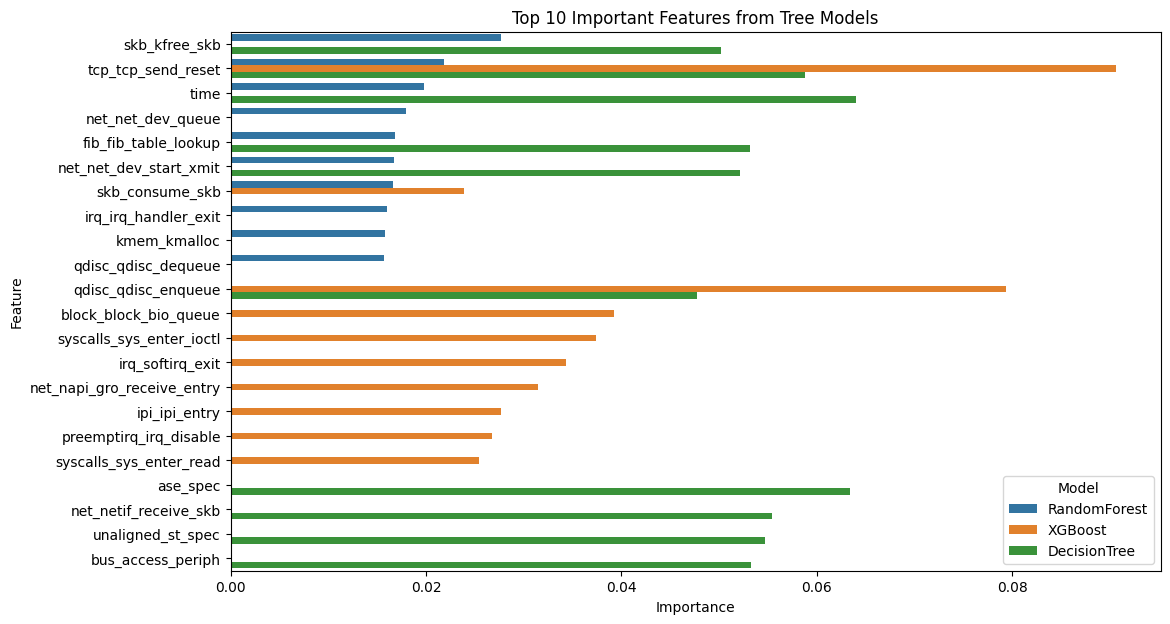


📊 Top 10 Features from Each Tree Model:
                       Feature  Importance         Model
0                skb_kfree_skb    0.027692  RandomForest
1           tcp_tcp_send_reset    0.021889  RandomForest
2                         time    0.019761  RandomForest
3            net_net_dev_queue    0.017970  RandomForest
4         fib_fib_table_lookup    0.016817  RandomForest
5       net_net_dev_start_xmit    0.016689  RandomForest
6              skb_consume_skb    0.016674  RandomForest
7         irq_irq_handler_exit    0.015969  RandomForest
8                 kmem_kmalloc    0.015762  RandomForest
9          qdisc_qdisc_dequeue    0.015716  RandomForest
10          tcp_tcp_send_reset    0.090645       XGBoost
11         qdisc_qdisc_enqueue    0.079337       XGBoost
12       block_block_bio_queue    0.039252       XGBoost
13    syscalls_sys_enter_ioctl    0.037386       XGBoost
14            irq_softirq_exit    0.034330       XGBoost
15  net_napi_gro_receive_entry    0.031491     

In [9]:
# -----------------------
# Feature Importance Extraction (after training)
# -----------------------
feature_names = train_df.drop(columns=["Attack"]).columns
all_fi = []

for r in results:
    model_name = r["Model"]
    model = models[model_name]

    if hasattr(model, "feature_importances_"):  # works for RF, DT, HGB
        fi_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": model.feature_importances_
        }).sort_values(by="Importance", ascending=False).head(10)
        fi_df["Model"] = model_name
        all_fi.append(fi_df)

    elif model_name == "XGBoost":  # special case
        fi_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": model.feature_importances_
        }).sort_values(by="Importance", ascending=False).head(10)
        fi_df["Model"] = model_name
        all_fi.append(fi_df)

# Combine all top 10s
if all_fi:
    fi_combined = pd.concat(all_fi, ignore_index=True)

    # Plot
    plt.figure(figsize=(12,7))
    sns.barplot(x="Importance", y="Feature", hue="Model", data=fi_combined)
    plt.title("Top 10 Important Features from Tree Models")
    plt.show()

    # Print table
    print("\n📊 Top 10 Features from Each Tree Model:")
    print(fi_combined)
else:
    print("No feature importances available for the selected models.")

In [10]:
# -----------------------
# Feature Importance Extraction
# -----------------------
feature_names = train_df.drop(columns=["Attack"]).columns
all_fi = []

for r in results:
    model_name = r["Model"]
    model = models[model_name]

    # Tree-based models (RF, DT, HGB, XGB)
    if hasattr(model, "feature_importances_"):
        fi_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": model.feature_importances_
        }).sort_values(by="Importance", ascending=False).head(10)
        fi_df["Model"] = model_name
        all_fi.append(fi_df)

# Combine into single table
if all_fi:
    fi_combined = pd.concat(all_fi, ignore_index=True)

    # Pivot table → models as columns, features as rows
    fi_table = fi_combined.pivot_table(
        index="Feature",
        columns="Model",
        values="Importance",
        fill_value=0
    )

    # Sort by sum of importance across models
    fi_table["Total_Importance"] = fi_table.sum(axis=1)
    fi_table = fi_table.sort_values(by="Total_Importance", ascending=False)

    print("\n📊 Top Features Across Models:")
    print(fi_table.head(15))   # show top 15

else:
    print("⚠️ No feature importances available for the selected models.")


📊 Top Features Across Models:
Model                       DecisionTree  RandomForest   XGBoost  \
Feature                                                            
tcp_tcp_send_reset              0.058824      0.021889  0.090645   
qdisc_qdisc_enqueue             0.047702      0.000000  0.079337   
time                            0.064019      0.019761  0.000000   
skb_kfree_skb                   0.050202      0.027692  0.000000   
fib_fib_table_lookup            0.053147      0.016817  0.000000   
net_net_dev_start_xmit          0.052184      0.016689  0.000000   
ase_spec                        0.063380      0.000000  0.000000   
net_netif_receive_skb           0.055392      0.000000  0.000000   
unaligned_st_spec               0.054724      0.000000  0.000000   
bus_access_periph               0.053302      0.000000  0.000000   
skb_consume_skb                 0.000000      0.016674  0.023917   
block_block_bio_queue           0.000000      0.000000  0.039252   
syscalls_sys_ente


📊 Top Features Across Models:
Model                           DecisionTree  LogisticRegression  \
Feature                                                            
unaligned_st_spec                   0.054724            0.875321   
strex_fail_spec                     0.000000            0.863853   
kmem_mm_page_alloc                  0.000000            0.861927   
skb_kfree_skb                       0.050202            0.673781   
kmem_rss_stat                       0.000000            0.637665   
kmem_mm_page_free                   0.000000            0.626857   
mem_access                          0.000000            0.587096   
syscalls_sys_exit_newfstatat        0.000000            0.580000   
syscalls_sys_enter_newfstatat       0.000000            0.579965   
kmem_mm_page_alloc_zone_locked      0.000000            0.579883   
tcp_tcp_send_reset                  0.058824            0.000000   
qdisc_qdisc_enqueue                 0.047702            0.000000   
time             

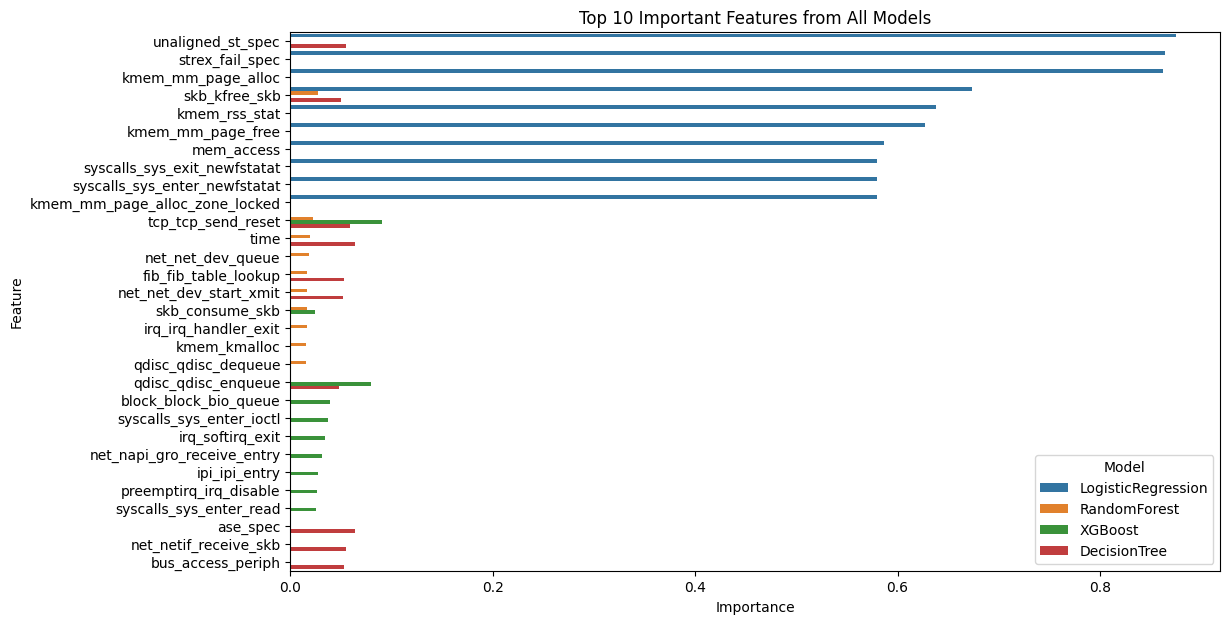

In [12]:
# -----------------------
# Feature Importance Extraction
# -----------------------
feature_names = train_df.drop(columns=["Attack"]).columns
all_fi = []

for r in results:
    model_name = r["Model"]
    model = models[model_name]  # ✅ Access trained model

    # 🌲 Tree-based models
    if hasattr(model, "feature_importances_"):
        fi_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": model.feature_importances_
        }).sort_values(by="Importance", ascending=False).head(10)
        fi_df["Model"] = model_name
        all_fi.append(fi_df)

    # 📈 Linear models (e.g., Logistic Regression, SVM)
    elif hasattr(model, "coef_"):
        importance = np.abs(model.coef_).mean(axis=0)  # average across classes
        fi_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importance
        }).sort_values(by="Importance", ascending=False).head(10)
        fi_df["Model"] = model_name
        all_fi.append(fi_df)

# Combine and visualize
if all_fi:
    fi_combined = pd.concat(all_fi, ignore_index=True)

    # Optional: Pivot for tabular comparison
    fi_table = fi_combined.pivot_table(
        index="Feature",
        columns="Model",
        values="Importance",
        fill_value=0
    )
    fi_table["Total_Importance"] = fi_table.sum(axis=1)
    fi_table = fi_table.sort_values(by="Total_Importance", ascending=False)

    # 🔍 Print top features
    print("\n📊 Top Features Across Models:")
    print(fi_table.head(15))

    # 📊 Plot
    plt.figure(figsize=(12,7))
    sns.barplot(x="Importance", y="Feature", hue="Model", data=fi_combined)
    plt.title("Top 10 Important Features from All Models")
    plt.show()
else:
    print("⚠️ No feature importances available for the selected models.")

In [13]:
# from sklearn.inspection import permutation_importance

# feature_names = train_df.drop(columns=["Attack"]).columns
# all_fi = []

# for r in results:
#     model_name = r["Model"]
#     model = models[model_name]

#     try:
#         # Tree-based models
#         if hasattr(model, "feature_importances_"):
#             importance = model.feature_importances_

#         # Linear models
#         elif hasattr(model, "coef_"):
#             importance = np.abs(model.coef_).mean(axis=0)

#         # Fallback for others (HGB, SVM, KNN, NaiveBayes)
#         else:
#             result = permutation_importance(
#                 model, X_val, y_val,
#                 n_repeats=5,
#                 random_state=42,
#                 scoring="f1_macro"
#             )
#             importance = result.importances_mean

#         # Build DataFrame
#         fi_df = pd.DataFrame({
#             "Feature": feature_names,
#             "Importance": importance
#         }).sort_values(by="Importance", ascending=False).head(10)
#         fi_df["Model"] = model_name
#         all_fi.append(fi_df)

#     except Exception as e:
#         print(f"⚠️ Skipping {model_name}: Importance extraction failed — {e}")

# # Combine and visualize
# if all_fi:
#     fi_combined = pd.concat(all_fi, ignore_index=True)

#     fi_table = fi_combined.pivot_table(
#         index="Feature",
#         columns="Model",
#         values="Importance",
#         fill_value=0
#     )
#     fi_table["Total_Importance"] = fi_table.sum(axis=1)
#     fi_table = fi_table.sort_values(by="Total_Importance", ascending=False)

#     print("\n📊 Top Features Across Models:")
#     print(fi_table.head(15))

#     plt.figure(figsize=(12,7))
#     sns.barplot(x="Importance", y="Feature", hue="Model", data=fi_combined)
#     plt.title("Top 10 Important Features from All Models")
#     plt.tight_layout()
#     plt.show()
# else:
#     print("⚠️ No feature importances available for the selected models.")

#Classification Report and Confusion Matix


================ LogisticRegression ================
Validation Results:
Accuracy: 0.8897893030794165
Macro F1: 0.7313928755100816

Classification Report:

                        precision    recall  f1-score   support

       aggressive-scan       0.60      0.47      0.53        19
         cryptojacking       1.00      1.00      1.00       180
            icmp-flood       0.73      0.85      0.79        13
    icmp-fragmentation       1.00      1.00      1.00        11
icmp-fragmentation_old       0.50      0.50      0.50         6
                  none       1.00      1.00      1.00       230
     os-fingerprinting       0.39      0.58      0.47        12
               os-scan       0.56      0.83      0.67         6
             port-scan       0.56      0.45      0.50        20
        push-ack-flood       1.00      1.00      1.00        13
      serice-detection       0.60      1.00      0.75         6
     service-detection       0.53      0.57      0.55        14
          

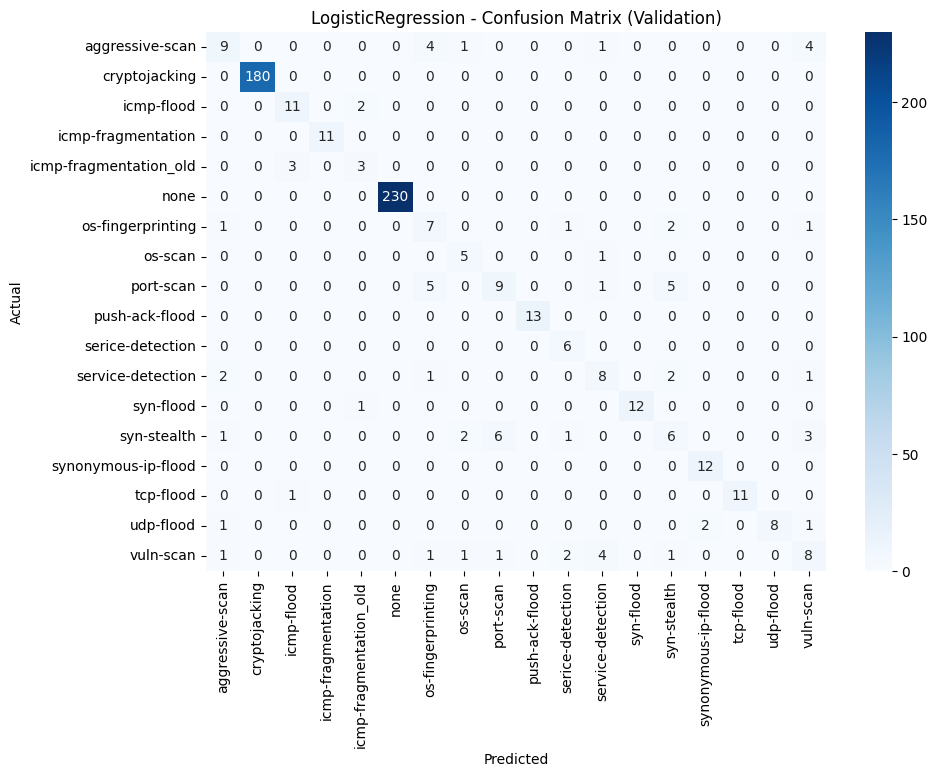


================ RandomForest ================
Validation Results:
Accuracy: 0.9043760129659644
Macro F1: 0.7661277109104537

Classification Report:

                        precision    recall  f1-score   support

       aggressive-scan       0.65      0.58      0.61        19
         cryptojacking       1.00      1.00      1.00       180
            icmp-flood       0.86      0.92      0.89        13
    icmp-fragmentation       0.92      1.00      0.96        11
icmp-fragmentation_old       0.80      0.67      0.73         6
                  none       1.00      1.00      1.00       230
     os-fingerprinting       0.54      0.58      0.56        12
               os-scan       0.45      0.83      0.59         6
             port-scan       0.70      0.70      0.70        20
        push-ack-flood       1.00      1.00      1.00        13
      serice-detection       0.62      0.83      0.71         6
     service-detection       0.39      0.50      0.44        14
             syn

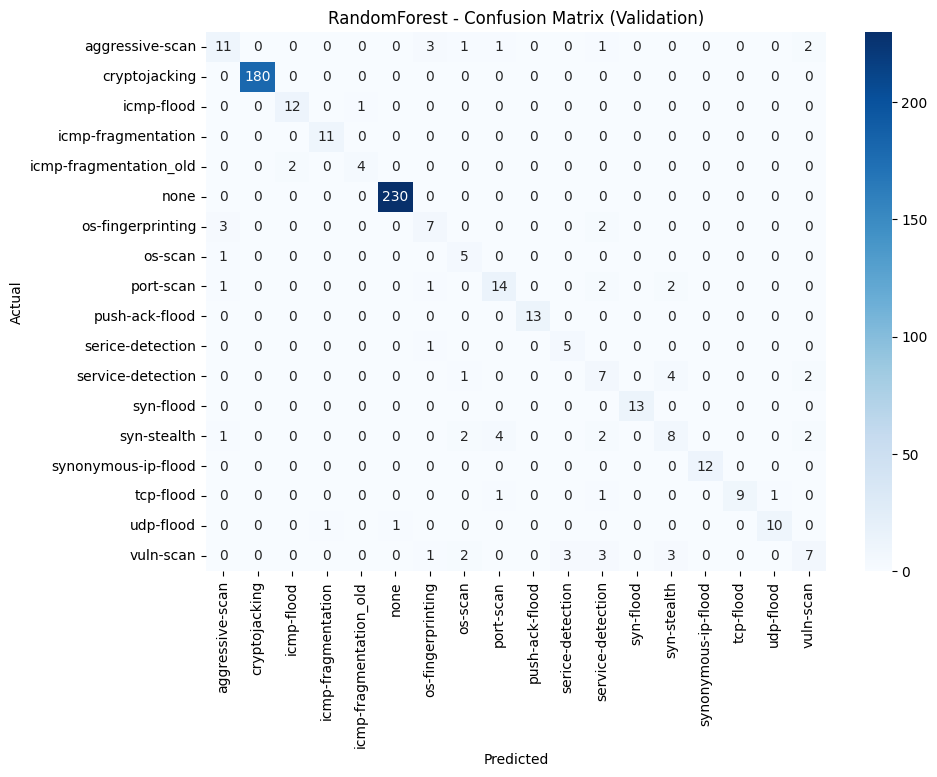


================ XGBoost ================
Validation Results:
Accuracy: 0.899513776337115
Macro F1: 0.7514051353444158

Classification Report:

                        precision    recall  f1-score   support

       aggressive-scan       0.77      0.53      0.62        19
         cryptojacking       1.00      1.00      1.00       180
            icmp-flood       0.75      0.92      0.83        13
    icmp-fragmentation       0.92      1.00      0.96        11
icmp-fragmentation_old       0.75      0.50      0.60         6
                  none       1.00      1.00      1.00       230
     os-fingerprinting       0.50      0.58      0.54        12
               os-scan       0.40      0.67      0.50         6
             port-scan       0.65      0.65      0.65        20
        push-ack-flood       1.00      1.00      1.00        13
      serice-detection       0.71      0.83      0.77         6
     service-detection       0.33      0.36      0.34        14
             syn-flood

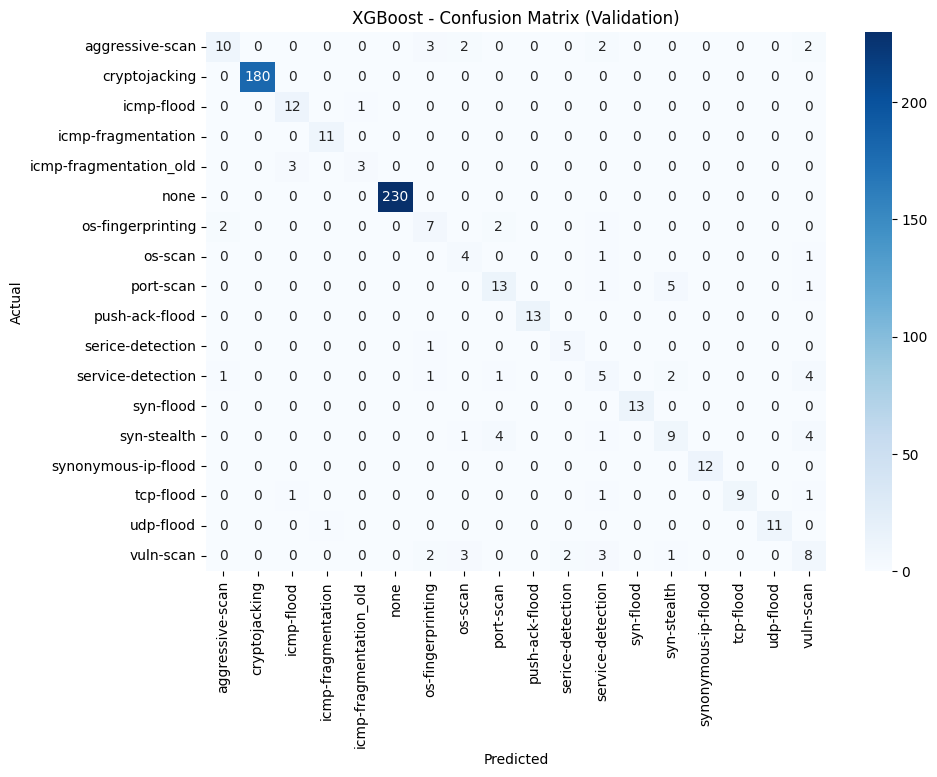


================ DecisionTree ================
Validation Results:
Accuracy: 0.8914100486223663
Macro F1: 0.7260529131715249

Classification Report:

                        precision    recall  f1-score   support

       aggressive-scan       0.82      0.47      0.60        19
         cryptojacking       1.00      1.00      1.00       180
            icmp-flood       0.71      0.77      0.74        13
    icmp-fragmentation       1.00      1.00      1.00        11
icmp-fragmentation_old       0.50      0.50      0.50         6
                  none       1.00      1.00      1.00       230
     os-fingerprinting       0.50      0.67      0.57        12
               os-scan       0.50      0.33      0.40         6
             port-scan       0.54      0.75      0.62        20
        push-ack-flood       1.00      1.00      1.00        13
      serice-detection       0.83      0.83      0.83         6
     service-detection       0.31      0.36      0.33        14
             syn

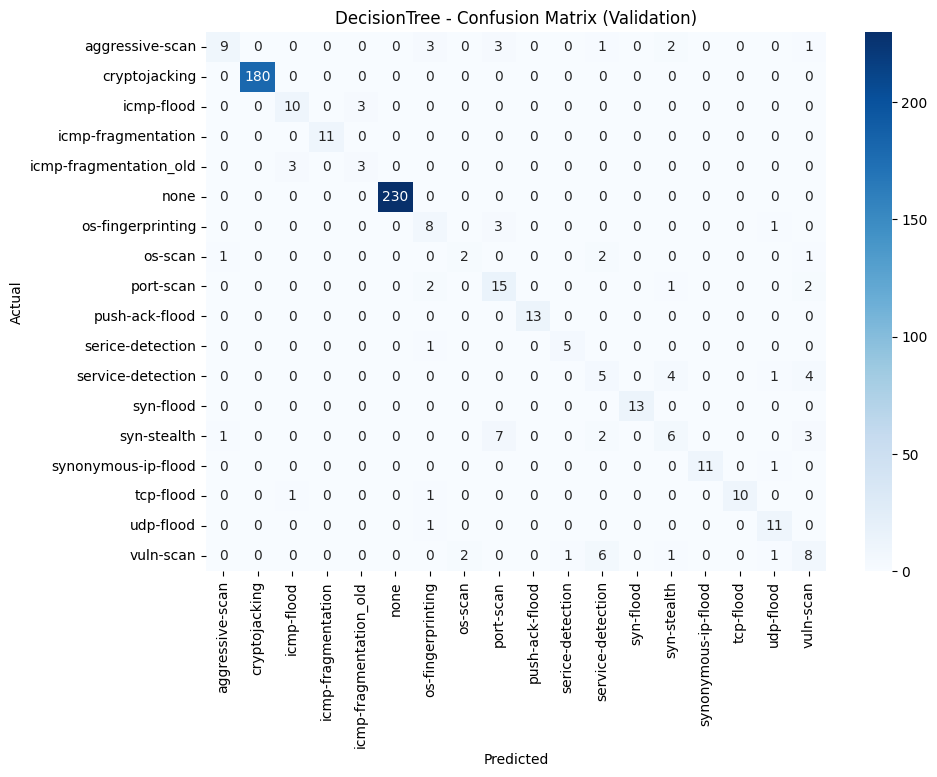


================ HistGradientBoosting ================
Validation Results:
Accuracy: 0.8881685575364667
Macro F1: 0.7318083351977696

Classification Report:

                        precision    recall  f1-score   support

       aggressive-scan       0.65      0.58      0.61        19
         cryptojacking       1.00      1.00      1.00       180
            icmp-flood       0.76      1.00      0.87        13
    icmp-fragmentation       0.92      1.00      0.96        11
icmp-fragmentation_old       1.00      0.50      0.67         6
                  none       1.00      1.00      1.00       230
     os-fingerprinting       0.50      0.50      0.50        12
               os-scan       0.50      0.50      0.50         6
             port-scan       0.46      0.60      0.52        20
        push-ack-flood       1.00      1.00      1.00        13
      serice-detection       0.71      0.83      0.77         6
     service-detection       0.32      0.43      0.36        14
        

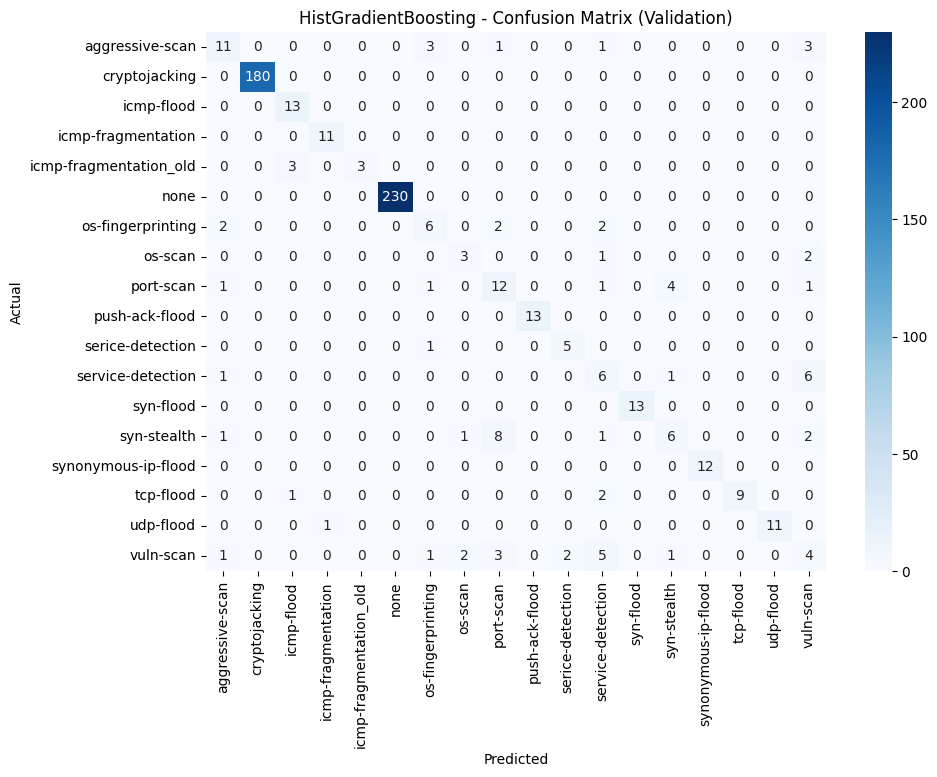


================ SVM ================
Validation Results:
Accuracy: 0.8622366288492707
Macro F1: 0.6517631923956717

Classification Report:

                        precision    recall  f1-score   support

       aggressive-scan       0.67      0.32      0.43        19
         cryptojacking       1.00      1.00      1.00       180
            icmp-flood       1.00      0.46      0.63        13
    icmp-fragmentation       1.00      1.00      1.00        11
icmp-fragmentation_old       0.40      1.00      0.57         6
                  none       1.00      1.00      1.00       230
     os-fingerprinting       0.24      1.00      0.39        12
               os-scan       0.38      1.00      0.55         6
             port-scan       0.80      0.40      0.53        20
        push-ack-flood       1.00      0.92      0.96        13
      serice-detection       0.25      0.83      0.38         6
     service-detection       0.57      0.29      0.38        14
             syn-flood   

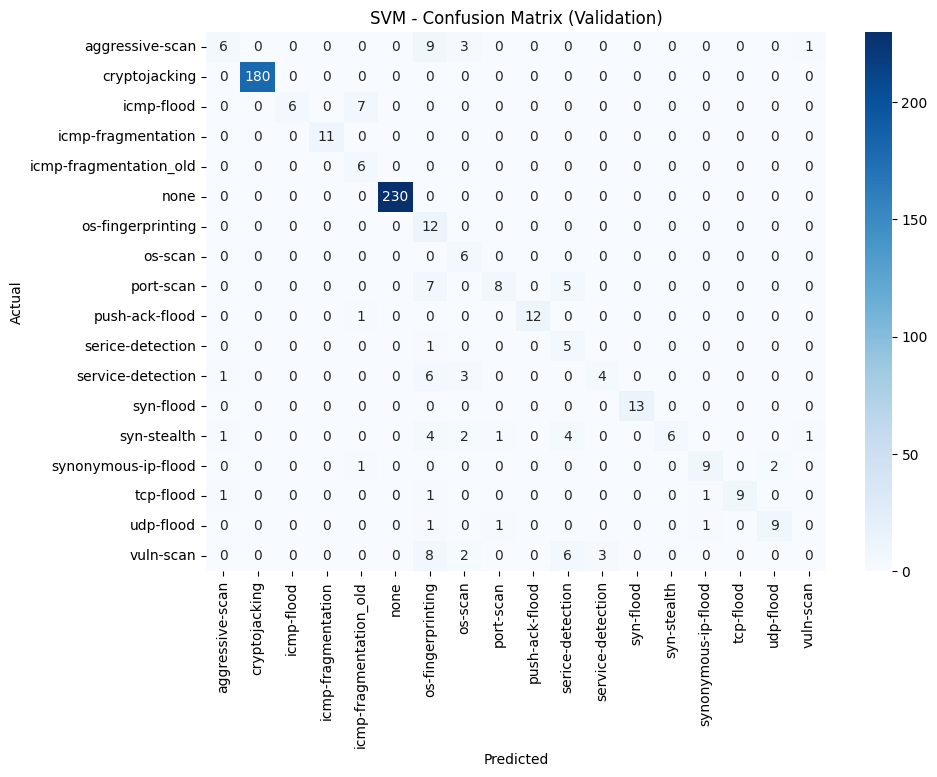


================ KNN ================
Validation Results:
Accuracy: 0.8557536466774717
Macro F1: 0.6308772073902319

Classification Report:

                        precision    recall  f1-score   support

       aggressive-scan       0.47      0.42      0.44        19
         cryptojacking       1.00      1.00      1.00       180
            icmp-flood       0.75      0.69      0.72        13
    icmp-fragmentation       0.85      1.00      0.92        11
icmp-fragmentation_old       0.45      0.83      0.59         6
                  none       0.99      1.00      1.00       230
     os-fingerprinting       0.29      0.58      0.39        12
               os-scan       0.25      0.33      0.29         6
             port-scan       0.67      0.50      0.57        20
        push-ack-flood       0.92      0.85      0.88        13
      serice-detection       0.33      0.50      0.40         6
     service-detection       0.47      0.50      0.48        14
             syn-flood   

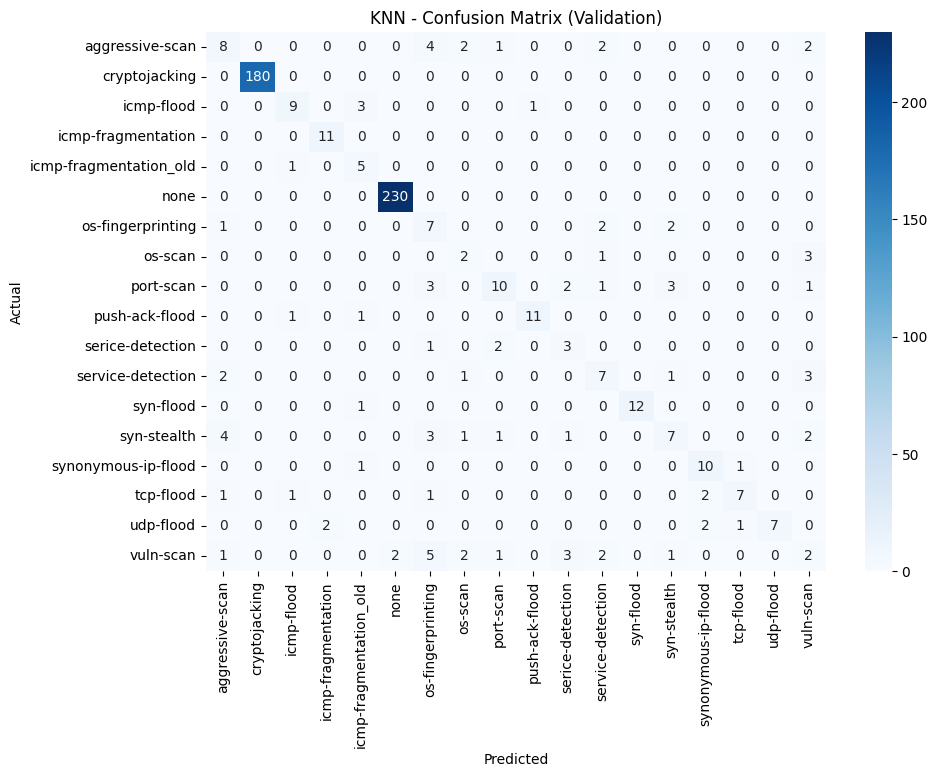


================ NaiveBayes ================
Validation Results:
Accuracy: 0.8022690437601296
Macro F1: 0.4801308446630239

Classification Report:

                        precision    recall  f1-score   support

       aggressive-scan       0.56      0.26      0.36        19
         cryptojacking       1.00      1.00      1.00       180
            icmp-flood       0.56      0.38      0.45        13
    icmp-fragmentation       0.77      0.91      0.83        11
icmp-fragmentation_old       0.23      0.83      0.36         6
                  none       0.96      1.00      0.98       230
     os-fingerprinting       0.18      0.33      0.24        12
               os-scan       0.24      1.00      0.39         6
             port-scan       0.40      0.10      0.16        20
        push-ack-flood       1.00      1.00      1.00        13
      serice-detection       0.15      1.00      0.26         6
     service-detection       0.00      0.00      0.00        14
             syn-f

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


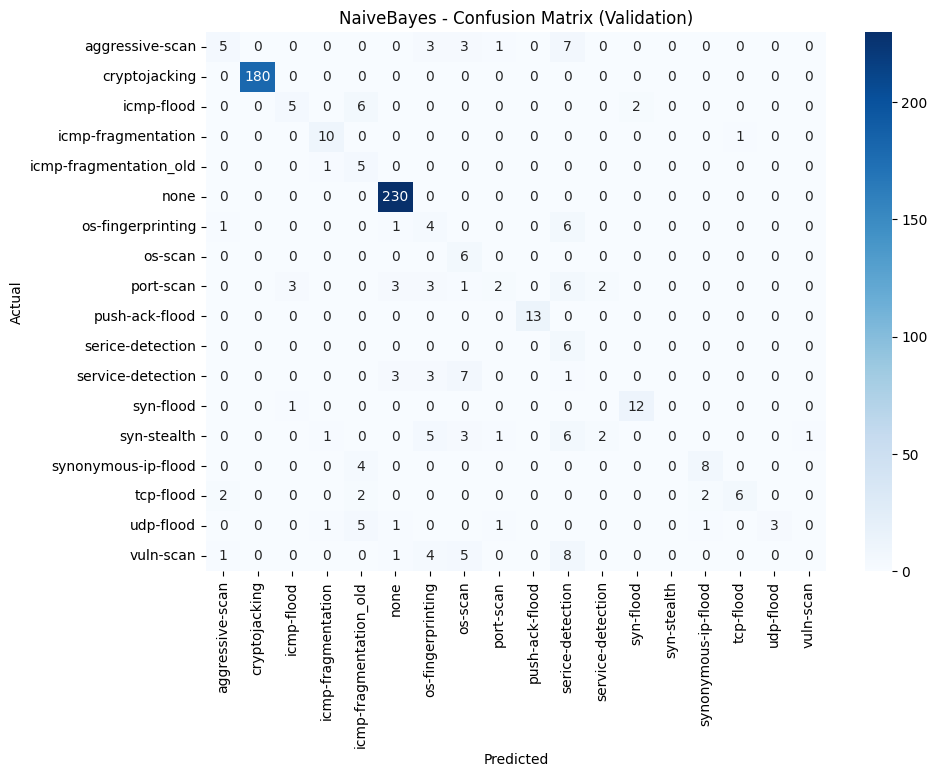

In [14]:
# -----------------------
# Print Results (separate block)
# -----------------------
for r in results:
    print(f"\n================ {r['Model']} ================")
    print("Validation Results:")
    print("Accuracy:", r["Accuracy"])
    print("Macro F1:", r["Macro_F1"])

    print("\nClassification Report:\n")
    print(classification_report(
        y_val,
        models[r["Model"]].predict(X_val),
        target_names=le.classes_
    ))

    print("\nTP/FP/FN/TN per class:")
    print(r["TFPN_Table"])

    # Plot confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(r["Confusion_Matrix"], annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{r['Model']} - Confusion Matrix (Validation)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

#ML Models Accuracy Table

In [15]:
# -----------------------
# Accuracy Comparison Table
# -----------------------
acc_table = pd.DataFrame([
    {"Model": r["Model"], "Accuracy": r["Accuracy"], "Macro_F1": r["Macro_F1"]}
    for r in results
])
print("\n📊 Accuracy Comparison Table:")
print(acc_table)


📊 Accuracy Comparison Table:
                  Model  Accuracy  Macro_F1
0    LogisticRegression  0.889789  0.731393
1          RandomForest  0.904376  0.766128
2               XGBoost  0.899514  0.751405
3          DecisionTree  0.891410  0.726053
4  HistGradientBoosting  0.888169  0.731808
5                   SVM  0.862237  0.651763
6                   KNN  0.855754  0.630877
7            NaiveBayes  0.802269  0.480131


In [16]:
results

[{'Model': 'LogisticRegression',
  'Accuracy': 0.8897893030794165,
  'Macro_F1': 0.7313928755100816,
  'Classification_Report': {'aggressive-scan': {'precision': 0.6,
    'recall': 0.47368421052631576,
    'f1-score': 0.5294117647058824,
    'support': 19.0},
   'cryptojacking': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 180.0},
   'icmp-flood': {'precision': 0.7333333333333333,
    'recall': 0.8461538461538461,
    'f1-score': 0.7857142857142857,
    'support': 13.0},
   'icmp-fragmentation': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 11.0},
   'icmp-fragmentation_old': {'precision': 0.5,
    'recall': 0.5,
    'f1-score': 0.5,
    'support': 6.0},
   'none': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 230.0},
   'os-fingerprinting': {'precision': 0.3888888888888889,
    'recall': 0.5833333333333334,
    'f1-score': 0.4666666666666667,
    'support': 12.0},
   'os-scan': {'precision': 0.5555555

In [17]:
#results.clear()